In [40]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Read Data

In [11]:
course_dict = pd.read_pickle('/Users/rafaelesteves/Downloads/all_cs_reviews.pickle')
courses = course_dict.keys()
course_df = pd.DataFrame(columns=
                         ["Course", "Comment", "Learning", 
                          "Difficulty", "Instructor"] #, "Term", "Instructor"
                        )
idx = 0
for course, comment_list in course_dict.items():
    for curr_comment in comment_list:
        curr_row = pd.DataFrame([[course, curr_comment, 0, 0, 0]],
                                columns = ["Course", "Comment", "Learning", 
                                           "Difficulty", "Instructor"], #, "Term", "Instructor"
                                index=[idx]
                        )
        course_df = course_df.append(curr_row)
        idx += 1
print(course_df)

         Course                                            Comment Learning  \
0       CS%201C  It's a very chill class where you get to talk ...        0   
1       CS%201C  It is a fun way to get to know dorm mates and ...        0   
2       CS%201C  This course is not only a way for you to get t...        0   
3       CS%201C  Fun and easy-going class. Taught by your fello...        0   
4       CS%201C  This is a great class and you also learn a lot...        0   
...         ...                                                ...      ...   
29927  CS%20230  This class is a phenomenal introduction to dee...        0   
29928  CS%20230  It's worth taking, especially if you want to g...        0   
29929  CS%20230  It's an AMAZING course. You will learn a varie...        0   
29930  CS%20230  Take one of the other deep learning courses in...        0   
29931  CS%20230  very useful; should definitely take it if ther...        0   

      Difficulty Instructor  
0              0     

# Heuristic Label

In [33]:
keywords = {
#     "fun":["very fun", "very enjoyable", "super fun class"],
#     "not fun": ["not fun at all"],
    
    
    "+ Difficulty":["very difficult", 
                  "take a lot of time",
                  "is a LOT of work", 
                  "very challenging",
                  "start assignments early", 
                  "a lot of work", 
                  "time consuming",
                  "extremely packed", 
                  "consumes a lot of time", 
                  "huge workload",
                  "challenging", 
                  "difficult", 
                  "hard", 
                  "struggle"
                 ],
    "- Difficulty":["not too much work", 
                     "not too challenging", 
                     "not to hard",
                     "easy class",
                     "small workload", 
                     "chill class", 
                     "easy course", 
                     "light workload",
                     "easy"
                    ],
    
    
#     "waste of time":["waste of time", "not worth it"],
    
    
    "+ Instructor":["very supportive", 
                  "very well-taught", 
                  "really supported", 
                  "amazing instructor", 
                  "instructor was very knowledgable", 
                  "very well taught", 
                  "is a very good teacher", 
                  "very well-designed",
                  "one of the best professors", 
                  "amazing professor", 
                  "the most knowledgeable",
                   "not well taught",
                   ],
    "- Instructor":["don't take it with", 
                      "the worst teacher", 
                      "learn on your own", 
                      "figure out on your own", 
                      "feels unorganized",
                        "not well taught",
                   ],
    
    
    "+ Learning":["useful assignments", 
                "learned a lot",
                "learn a lot", 
                "learn important skills", 
                "extremely useful",
                "very useful" 
                "a lot of work but worth it", 
                "assignments were useful", 
                "hands on", 
                "accomplished", 
                "accomplishment", 
                "foundation", 
                "learn", 
                "building block", 
                "helpful", 
                "covers"
               ],
    "- Learning":[ "only at a surface level", 
                   "shallow", 
                   "won't dive into much detail", 
                   "don't learn much", 
                   "introductory", 
                   "boring",
                  ],
    
    
#     "no background requirement":["nice introduction", "nice introductory", "very approachable introduction","very accessible","good survey", "good intro class", "nice intro class",
#                              ],
#     "requires background":["not an intro class", "not an introductory class"],
#     "positive":["take it", "would recommend"],
#     "negative":["don't take it", "wouldn't recommend"]
}

In [31]:
# Naive Loop Approach
num_rows = course_df.shape[0]
attributes = ["Difficulty", "Instructor", "Learning"]

for idx in tqdm(range(num_rows)):
    curr_row = course_df.iloc[idx]
    curr_comment = curr_row["Comment"]
#     print(curr_comment)
    for curr_attr in attributes:
        attr = sum([1 if phrase in curr_comment else 0 for phrase in keywords[f"+ {curr_attr}"]]) \
            - sum([1 if phrase in curr_comment else 0 for phrase in keywords[f"- {curr_attr}"]])
        curr_row[curr_attr] = attr
#     print(course_df.iloc[idx], curr_row)
    course_df.iloc[idx] = curr_row # maybe we can change row in place instead?
course_df

100%|████████████████████████████████████| 29932/29932 [01:06<00:00, 447.17it/s]


,Course,Comment,Learning,Difficulty,Instructor
0,CS%201C,It's a very chill class where you get to talk ...,1,-1,0
1,CS%201C,It is a fun way to get to know dorm mates and ...,1,0,0
2,CS%201C,This course is not only a way for you to get t...,0,0,0
3,CS%201C,Fun and easy-going class. Taught by your fello...,0,-1,0
4,CS%201C,This is a great class and you also learn a lot...,2,0,0
...,...,...,...,...,...
29927,CS%20230,This class is a phenomenal introduction to dee...,1,0,0
29928,CS%20230,"It's worth taking, especially if you want to g...",1,0,0
29929,CS%20230,It's an AMAZING course. You will learn a varie...,1,0,0
29930,CS%20230,Take one of the other deep learning courses in...,1,0,0


In [56]:
print(course_df.iloc[25765])

Course                                                                                                                                                                                                       CS%20109
Comment       This class is so hard but so rewarding. Chris Piech is an incredible lecturer and really makes the content feel relevant and interesting. The problem sets can be very difficult and time consuming,...
Learning                                                                                                                                                                                                            0
Difficulty                                                                                                                                                                                                          4
Instructor                                                                                                                                      

In [55]:
print(course_df.loc[course_df["Difficulty"]==0]["Comment"])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
course_df.sort_values("Difficulty")

,Course,Comment,Learning,Difficulty,Instructor
9088,CS%20227B,Class is not well taught and you don't learn a...,1,-3,0
19325,CS%20157,"It is a chill class, all the lessons needed to...",0,-3,0
6062,CS%20145,Fairly easy course that gives a light overview...,1,-2,0
1396,CS%20105,"Regardless of coding experience, it's a very e...",0,-2,0
21887,CS%20255,"If you're a Math major, then this will be an e...",0,-2,0
...,...,...,...,...,...
25765,CS%20109,This class is so hard but so rewarding. Chris ...,0,4,0
26037,CS%20110,It is a very challenging course and the homewo...,0,4,0
24431,CS%20103,"Take it! But be sure to pay attention, work ha...",0,4,0
11884,CS%20238,The professor is super nice and very willing t...,0,4,0


In [35]:
course_df["Difficulty"].value_counts()

 0    24074
 1     4190
-1      739
 2      729
 3      102
-2       87
 4        9
-3        2
Name: Difficulty, dtype: int64

# Visualize Data

In [43]:
# Comment Attribute Visualization

def plot_comment_attr(df, attribute):
    count_series = df[attribute].value_counts()
    count_map = count_series.to_dict()
    
    x = count_map.keys()
    heights = count_map.values()
    
    plt.title(f"{attribute} values")
    plt.bar(x, heights)
    plt.show()

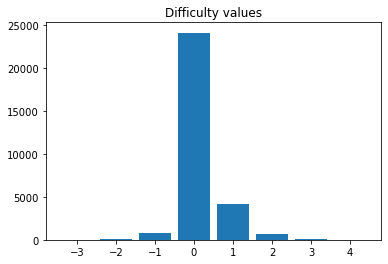

In [44]:
plot_comment_attr(course_df, "Difficulty")

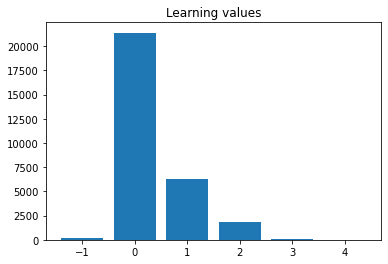

In [46]:
plot_comment_attr(course_df, "Learning")

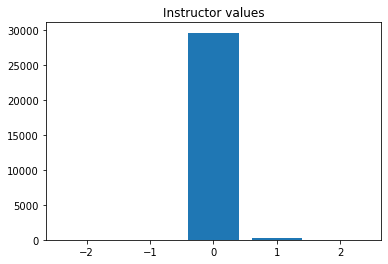

In [45]:
plot_comment_attr(course_df, "Instructor")

# Split Data

# Train Bert

# Infer